In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('predictions/xgboost_2025_12.csv')

actual = df['actual']
predicted = df['predicted']
df['error'] = abs(actual - predicted)

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

df = df[df['error'] != 0]

plt.figure(figsize=(10, 6))
bins = np.arange(df['error'].min(), df['error'].max(), 100)
plt.hist(df['error'], bins=bins, color='lightblue', edgecolor='black')
plt.title('Error Distribution (Actual vs Predicted)')
plt.xlabel('Error (Absolute Difference)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df['relative_error'] = df['error'] / df['actual']
plt.figure(figsize=(10,6))
plt.scatter(df['actual'], df['relative_error'], alpha=0.4, color='steelblue', edgecolors='black')
plt.xlabel('Actual Production Quantity')
plt.ylabel('Relative Error (|Prediction - Actual| / Actual)')
plt.title('Relative Error vs Actual Production Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'predictions/xgboost_2025_11.csv'

Total production quantity: 436000
Number of articles: 3155


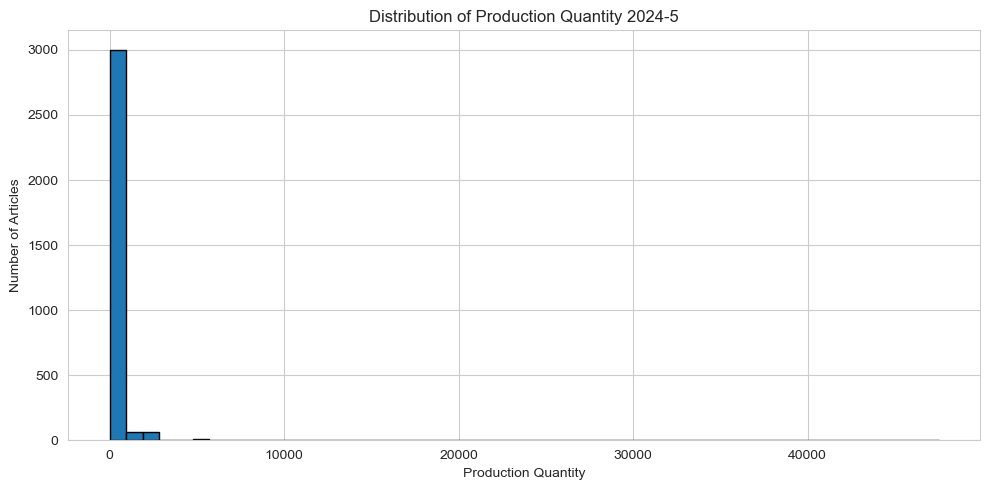

In [35]:
YEAR = 2024
WEEK = 5

df = pd.read_csv('data/processed_data.csv')
df = df[(df['year'] == YEAR) & (df['calendar_week'] == WEEK)]

total_production = df['production'].sum()
article_count = len(df)

print(f"Total production quantity: {total_production}")
print(f"Number of articles: {article_count}")

plt.figure(figsize=(10, 5))
plt.hist(df['production'], bins=50, edgecolor='black')
plt.title(f'Distribution of Production Quantity {YEAR}-{WEEK}')
plt.xlabel('Production Quantity')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()
plt.show()

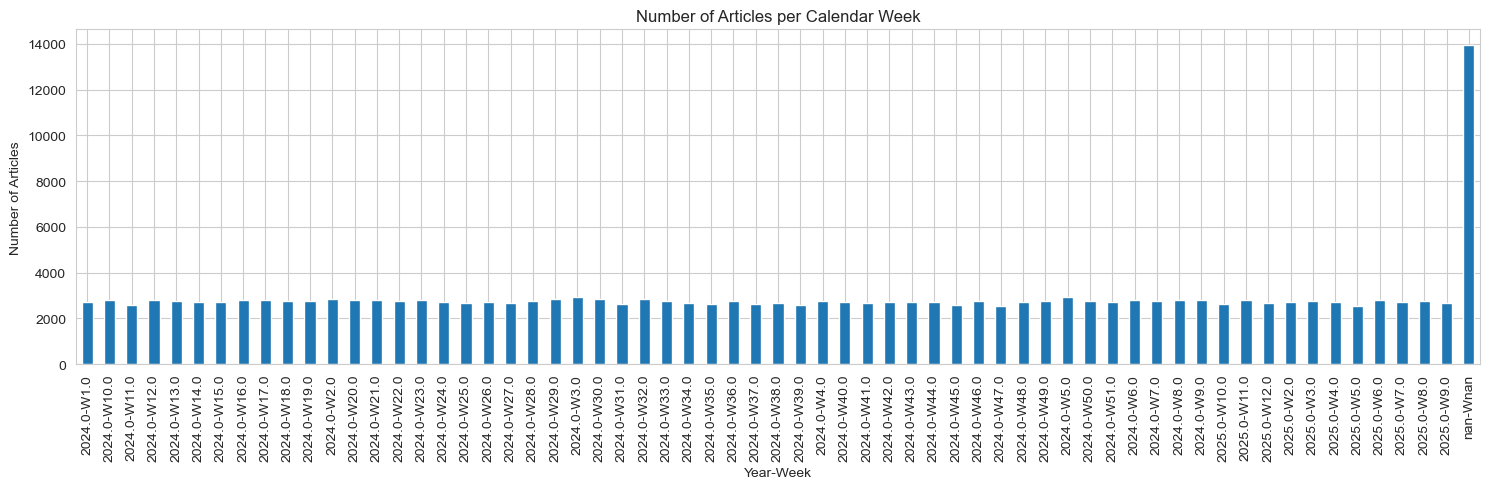

In [42]:
df = pd.read_csv('data/transformed_data.csv')

df['year_week'] = df['year'].astype(str) + '-W' + df['calendar_week'].astype(str).str.zfill(2)

weekly_counts = df['year_week'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
weekly_counts.plot(kind='bar')
plt.title('Number of Articles per Calendar Week')
plt.xlabel('Year-Week')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

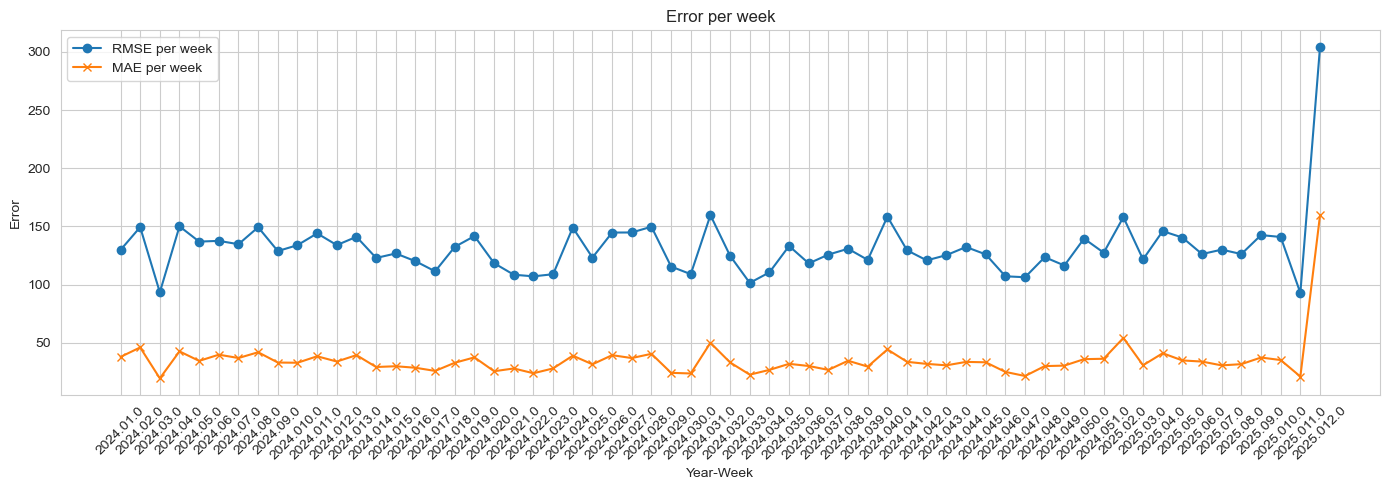

In [37]:
df = pd.read_csv('predictions/xgboost_2000_weekly.csv')
df['year_week'] = df['year'].astype(str) + df['week'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 5))
plt.plot(df['year_week'], df['rmse'], label='RMSE per week', marker='o')
plt.plot(df['year_week'], df['mae'], label='MAE per week', marker='x')
plt.legend()
plt.title('Error per week')
plt.xlabel('Year-Week')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

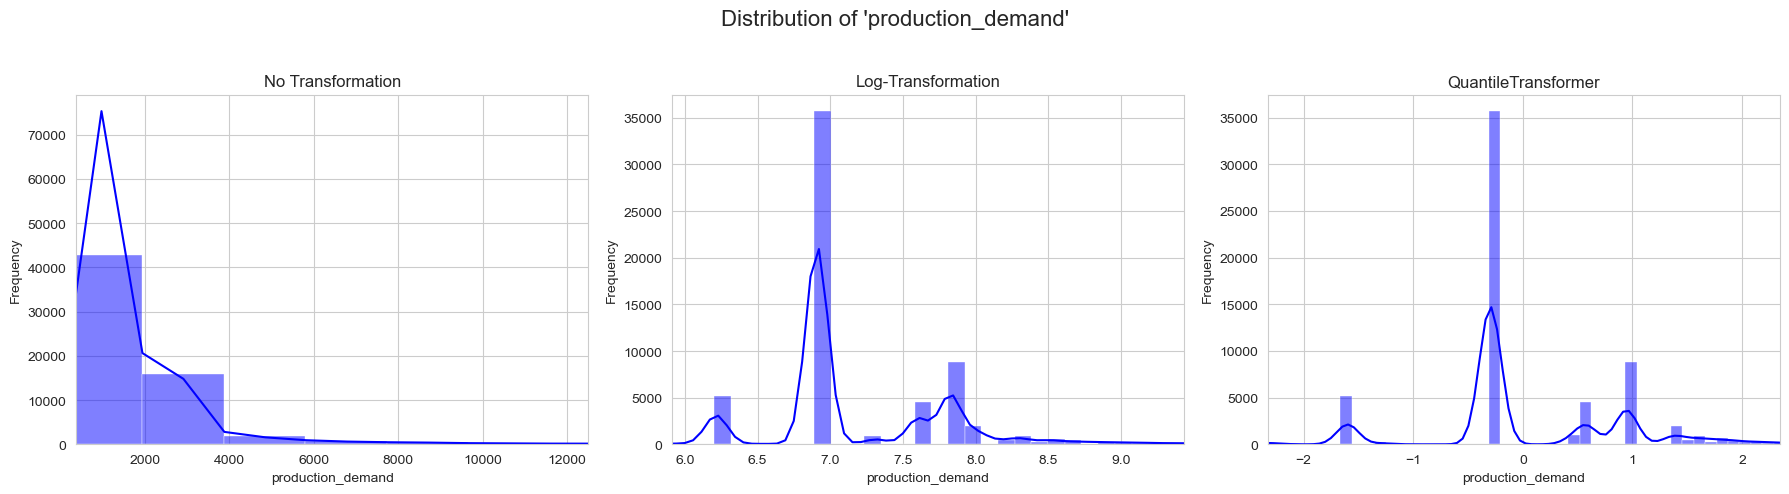

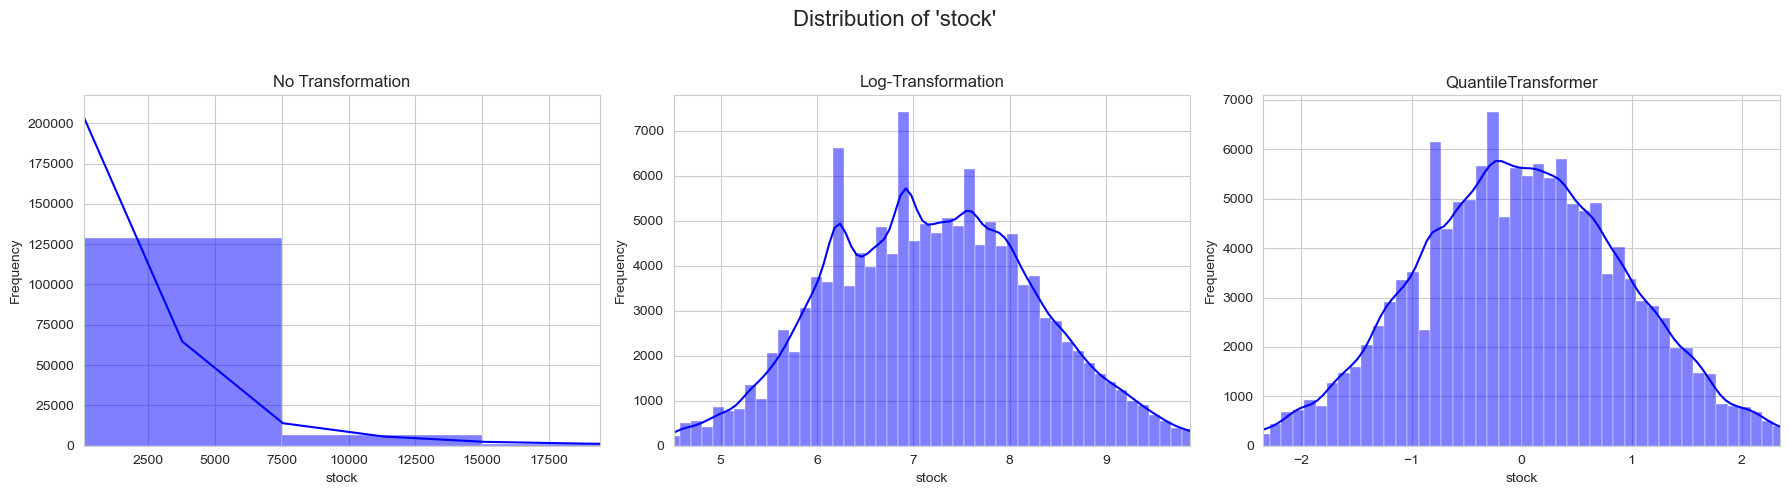

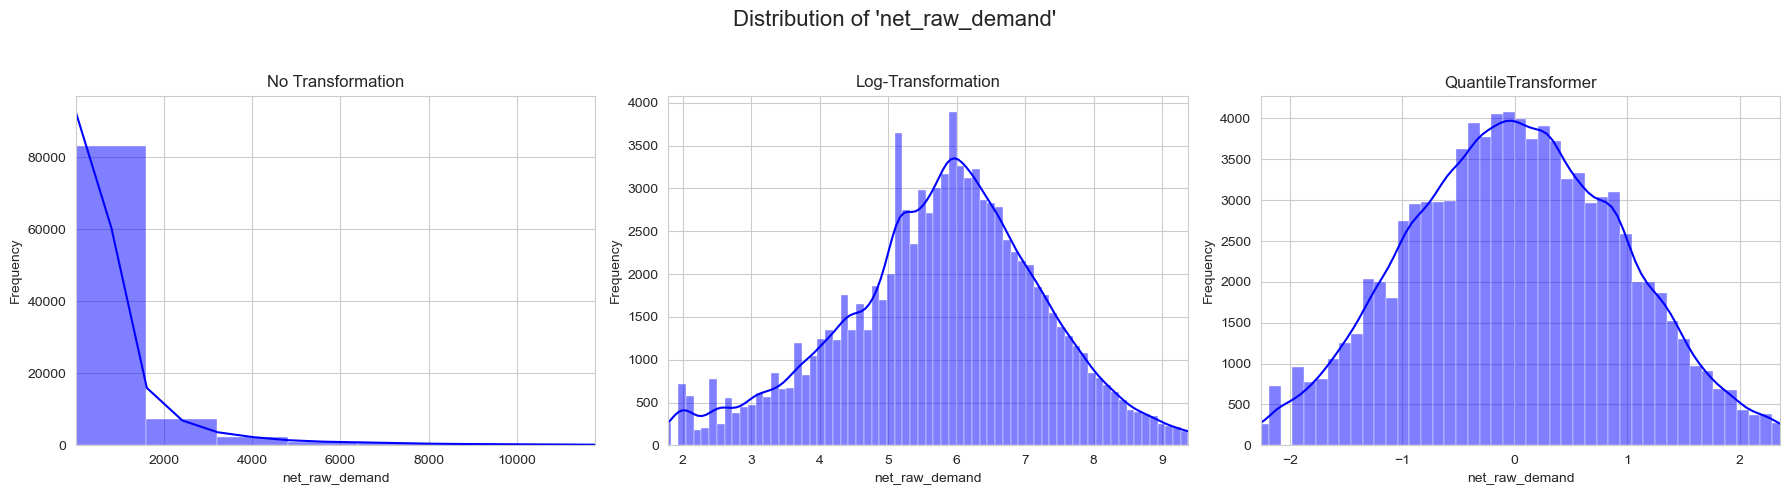

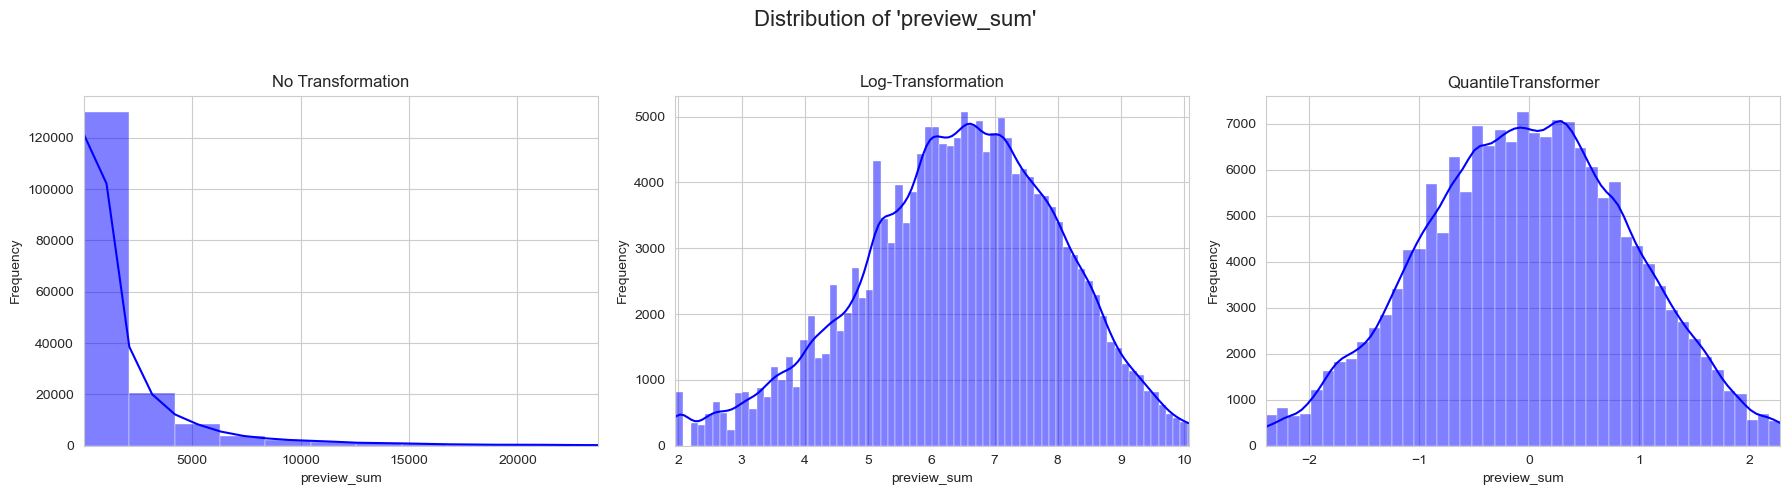

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import QuantileTransformer

df = pd.read_csv('data/processed_data.csv')
#df = df[(df['production_demand'] <= 2000)]

features = ['production_demand', 'stock', 'net_raw_demand', 'preview_sum']

transformers = {
    'No Transformation': None,
    'Log-Transformation': lambda x: np.log1p(x),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

for feature in features:
    if feature not in df.columns:
        continue

    feature_data = df[df[feature] > 0].copy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Distribution of '{feature}'", fontsize=16)

    for ax, (name, transformer) in zip(axes, transformers.items()):
        transformed_data = feature_data[[feature]].copy()

        if transformer is None:
            transformed_data[feature] = feature_data[feature]
        elif callable(transformer):
            transformed_data[feature] = transformer(feature_data[feature])
        else:
            transformed_data[feature] = transformer.fit_transform(feature_data[[feature]])

        sns.histplot(transformed_data[feature], bins=100, kde=True, color='blue', ax=ax)
        ax.set_title(name)
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.grid(True)
        ax.set_xlim(
            transformed_data[feature].quantile(0.01),
            transformed_data[feature].quantile(0.99)
        )

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()



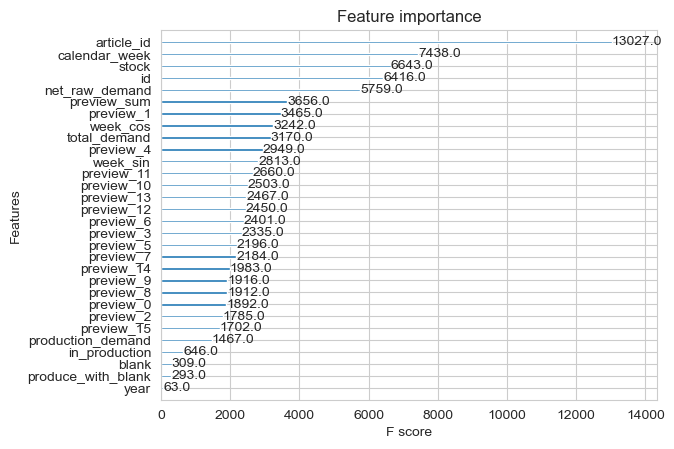

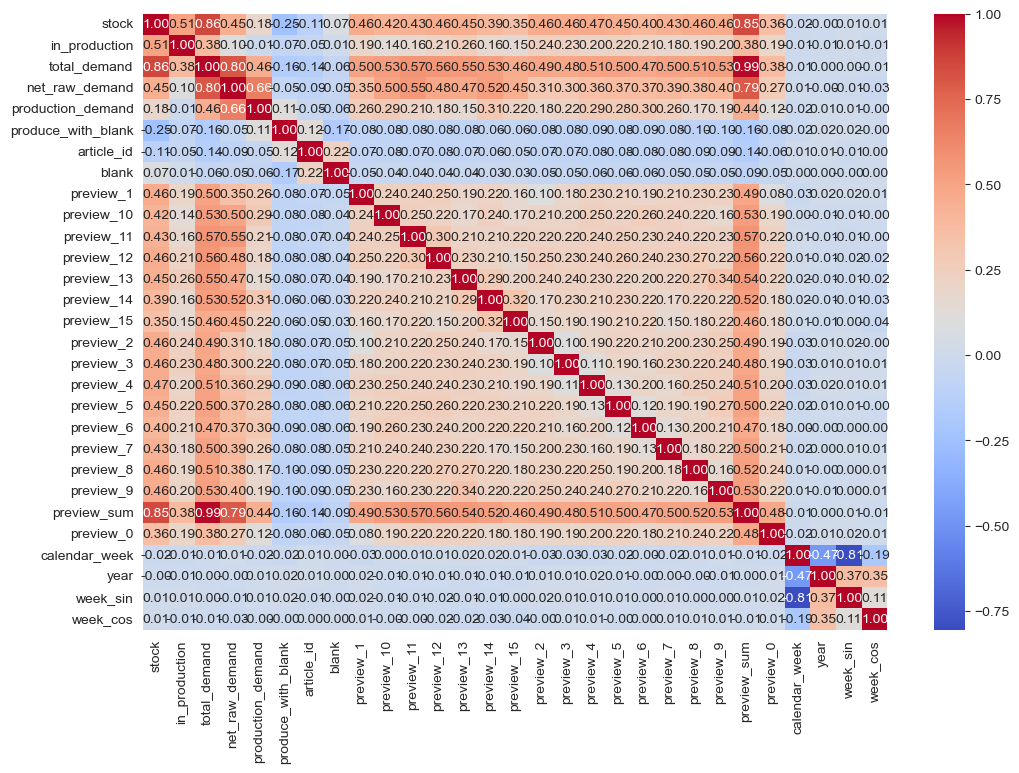

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from train_model import Y_COLUMN_NAME

df = pd.read_csv('data/processed_data.csv')
df.drop('id', axis=1, inplace=True)

x = df.drop(columns=[Y_COLUMN_NAME])
y = df[Y_COLUMN_NAME]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

def plot_feature_importance():
    with open(f'models/xgboost.pkl', 'rb') as f:
        model = pickle.load(f)

    xgb.plot_importance(model)
    plt.show()

def plot_correlation_matrix(x_train):
    plt.figure(figsize=(12, 8))
    correlation_matrix = x_train.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.show()

plot_feature_importance()
plot_correlation_matrix(x_train)

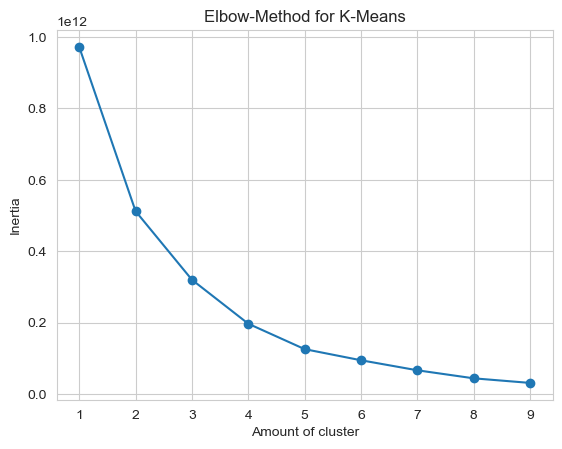

            count          mean           std      min      25%      50%  \
cluster                                                                    
0        183292.0    489.123137    889.323390      0.0      0.0      0.0   
1          1546.0  13100.781371   7599.595778   7000.0   8000.0  10000.0   
2            69.0  77514.492754  35567.248961  46500.0  54000.0  63000.0   

             75%       max  
cluster                     
0         1000.0    6785.0  
1        15000.0   45000.0  
2        90000.0  193000.0  


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv('data/processed_data.csv')

x = df[['production_demand']].values

inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Amount of cluster')
plt.ylabel('Inertia')
plt.title('Elbow-Method for K-Means')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(x)

print(df.groupby('cluster')['production_demand'].describe())
